In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as snb
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import re

In [2]:
train_bio = pd.read_csv("input_light/biology.csv",encoding='utf-8')
train_cooking = pd.read_csv("input_light/cooking.csv",encoding='utf-8')
train_crypto = pd.read_csv("input_light/crypto.csv",encoding='utf-8')
train_dyi = pd.read_csv("input_light/diy.csv",encoding='utf-8')
train_robotic = pd.read_csv("input_light/robotics.csv",encoding='utf-8')
train_travel = pd.read_csv("input_light/travel.csv",encoding='utf-8')
# test_df = pd.read_csv("input_light/test.csv",encoding='utf-8')

In [12]:
# df_list = []
df_list = pd.concat([train_bio,train_cooking,train_crypto,train_dyi,train_robotic,train_travel])

## Length of dataset

In [13]:
df_list.head()

,id,title,content,tags
0,1,criticality ribosome binding site relative sta...,prokaryotic translation critical efficient tra...,ribosome binding-sites translation synthetic-b...
1,2,rnase contamination rna based experiments prev...,anyone suggestions prevent rnase contamination...,rna biochemistry
2,3,lymphocyte sizes clustered two groups,tortora writes principles anatomy physiology l...,immunology cell-biology hematology
3,4,long antibiotic dosed lb maintain good selection,various people lab prepare liter lb add kanamy...,cell-culture
4,5,exon order always preserved splicing,cases splicing machinery constructs mrna exons...,splicing mrna spliceosome introns exons


In [18]:
df_list.dropna(axis=0,how='any',inplace=True)

In [24]:
df_concat = df_list['title'] + ' ' + df_list['content']

In [26]:
df_list['doc'] = df_concat.map(lambda d: d.replace('-','_'))

In [27]:
print "Total length = %s"%df_list.shape[0]

Total length = 86998


In [28]:
print "Length of null data = %s"%df_list[df_list['doc'].isnull()].shape[0]

Length of null data = 0


In [29]:
print "Length of null data = %s"%df_list[df_list['tags'].isnull()].shape[0]

Length of null data = 0


## Number of unique tags in training datasets

In [10]:
df_list['tags'][0:10]

0    ribosome binding-sites translation synthetic-b...
1                                     rna biochemistry
2                   immunology cell-biology hematology
3                                         cell-culture
4              splicing mrna spliceosome introns exons
5                   dna biochemistry molecular-biology
6                                neuroscience synapses
7                                             plasmids
8    molecular-genetics gene-expression experimenta...
9                  evolution mitochondria chloroplasts
Name: tags, dtype: object

In [33]:
# Y = [item.replace("-","_").split(" ") for item in df_list['tags']]
all_tags = df_list['tags'].map(lambda d: d.replace('-','_'))

In [12]:
length_of_tags = pd.DataFrame(zip(*np.unique([len(tag) for tag in Y],return_counts=True)),columns=['length','count'])

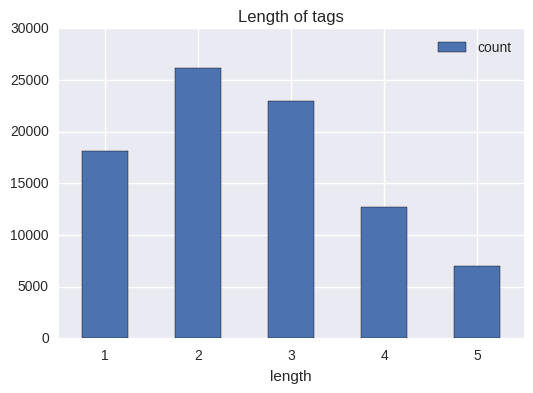

In [13]:
%matplotlib inline
# ax = plt.subplot()
# ax.plot(length_of_tags['length'],label='')
ax = length_of_tags.set_index("length").plot(kind='bar',rot=0,title="Length of tags")

## Analyze type of data

In [30]:
type_of_tags = []

def get_post_tag(tags):
    return np.array(nltk.pos_tag(tags.split(' ')))[:,1]

for tag in df_list.tags:
    type_of_tags.extend(get_post_tag(tag))

count_tag = pd.DataFrame(zip(*np.unique(type_of_tags,return_counts=True)),columns=['tag','count'])

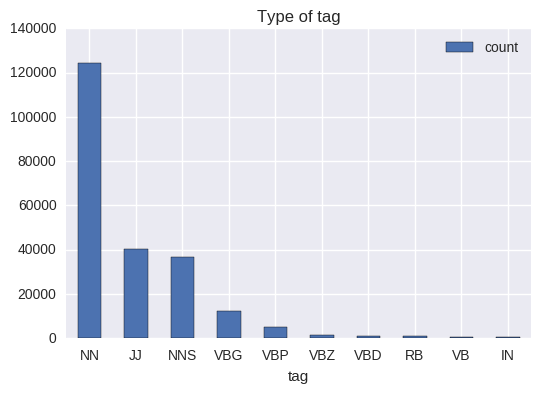

In [31]:
%matplotlib inline
count_tag.sort_values(['count'],ascending=False).iloc[0:10].set_index(['tag']).plot(kind='bar',title="Type of tag",rot=0)

## Number of tags in title

In [ ]:
def remove_number(demo):
    a = []
    for f in demo.split(' '):
        if not(f.isdigit()):
            a.append(f)
    return a

In [94]:
# token_pattern='^[0-9]*'
word_title = [remove_number(item) for item in df_list['title']]
title_dict = list(set(sum(word_title,[])))

In [95]:
title_dict = set(title_dict)

In [96]:
number_of_tags_in_title = title_dict.intersection(tags)

In [97]:
print "Ratio of tags in title = %s %%"%(len(number_of_tags_in_title)*100/len(all_tags))

Ratio of tags in title = 1 %


## TF-IDF + LDA

In [35]:
tfidfVec = TfidfVectorizer(max_df=0.95)
countVec = CountVectorizer(max_df=0.95,min_df=2,ngram_range=(1,2),token_pattern='[a-zA-Z]{2,}')

In [36]:
df_tf = countVec.fit_transform(df_list['doc'])

In [37]:
n_topics = 6

In [44]:
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=4111,n_jobs=2)
lda.fit(df_tf)

KeyboardInterrupt: 

In [ ]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [ ]:
print("\nTopics in LDA model:")
n_top_words = 30
tf_feature_names = countVec.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

In [ ]:
idx = lda.transform(df_tf[0]).argmax()

# words_topic = zip(*(lda.components_[3],countVec.get_feature_names()))
words_topic = lda.components_[idx]
feature_names = countVec.get_feature_names()
n_words = 100

print [feature_names[i] for i in words_topic.argsort()[:-n_words - 1:-1]]

In [42]:
tokenizer = countVec.build_analyzer()
a = tokenizer(df_list['title'].iloc[0])
b = [(c,words_topic[countVec.vocabulary_[c]]) for c in a if countVec.vocabulary_.has_key(c)]

In [43]:
df_list['tags'].iloc[0]

u'ribosome binding-sites translation synthetic-biology'